# ASL recognition

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog
import matplotlib.pyplot as plt
import math
import time

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from numpy.dtypes import StringDType

In [26]:
def quality(M,XT,YT):
    Yp = M.predict(XT)
    print('ACC: ' + format(accuracy_score(YT,Yp),".3f"))
    print('BAC: ' + format(balanced_accuracy_score(YT,Yp),".3f"))
    print('f1: ' + str(f1_score(YT, Yp, average='micro')))
    print('CM:\n')
    plt.matshow(confusion_matrix(YT,Yp))

times = dict()

In [4]:
folder_path = "./training-a-robot-to-understand-sign-language/signlanguage/signlanguage/"
all_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg')) and not f.startswith('.')]
img_size=64

y = []
X_raw = np.empty((len(all_files), img_size*img_size), dtype=np.uint8)

for i, filename in enumerate(tqdm(all_files, desc="Elaborazione")):
    label = filename.split('_')[0]
    img_path = os.path.join(folder_path, filename)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))

    if img is None:
        print("Error reading image!")
        break
    X_raw[i] = img.flatten()
    # X_raw[i] = preprocess_image(img)
    y.append( label)
y = np.array(y)

Elaborazione: 100%|████████████████████████████████████████████████████████████| 8476/8476 [00:03<00:00, 2619.60it/s]


In [5]:
print(X_raw.shape)
print(y.shape)

(8476, 4096)
(8476,)


['a' 'b' 'background' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'k' 'l' 'm' 'n' 'o' 'p'
 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y']


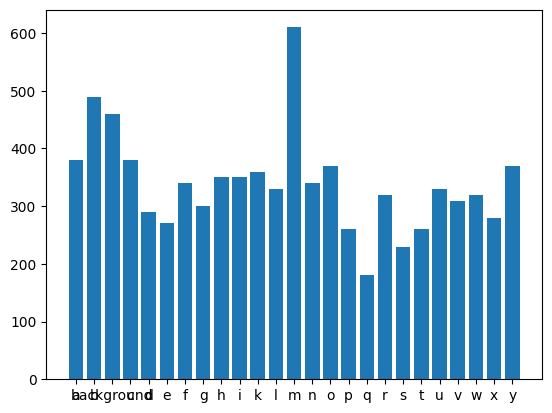

In [6]:
labels, count = np.unique(y, return_counts=True)
plt.bar(labels, count)
print(labels)

ACC: 0.985
BAC: 0.987
f1: 0.9852594339622641
CM:



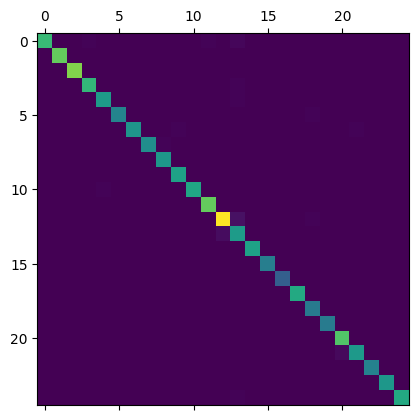

In [17]:
Xl, Xt, yl, yt = train_test_split(X_raw, y, test_size=0.2, random_state=11)
grid = {'C':                       np.logspace(-6,3,10),
        'kernel':                  ['linear'],
        'decision_function_shape': ['ovr']}
start_time = time.time()
M = GridSearchCV(estimator  = SVC(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'balanced_accuracy',
                 n_jobs = -2)

M.fit(Xl, yl)
times["raw_linear"] = time.time() - start_time

quality(M,Xt,yt)

## Preprocessing

preprocessing is done using HOG and PCA

In [7]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
def preprocess_image(img, ret_hog=False): 
    img = clahe.apply(img)

    # Estrazione HOG (orientations=9 è lo standard per i bordi)
    # Questo riduce l'immagine a un vettore di descrittori di forma
    return hog(img, orientations=9, pixels_per_cell=(8, 8),
               cells_per_block=(2, 2), visualize=ret_hog) 

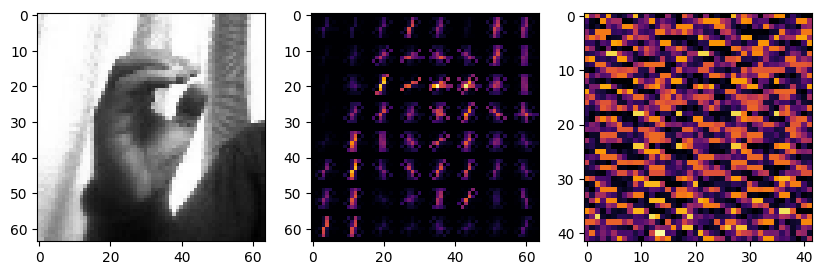

In [8]:
image = "c_1.png"

# 2. Caricamento e Preprocessing
img_path = os.path.join(folder_path, image)
img_raw = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_raw = cv2.resize(img_raw, (img_size, img_size))

img, img_hog = preprocess_image(img_raw, ret_hog=True)

# print(f"label: {label}")

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
axs[0].imshow(img_raw, cmap='gray')
axs[1].imshow(img_hog, cmap='inferno')
axs[2].imshow(img.reshape(42,42), cmap='inferno')

scaler = StandardScaler()
img_scaled = scaler.fit_transform(img.reshape(1, -1))

In [9]:
X_hog = np.apply_along_axis(lambda x: preprocess_image(x.reshape(img_size, img_size)), 1, X_raw)
X_hog.shape

(8476, 1764)

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_hog)

pca = PCA(n_components=0.95, random_state=42)
X = pca.fit_transform(X_scaled)

print(f"Original features: {X_hog.shape[1]} -> Final features: {X.shape[1]}, kept {100*X.shape[1]/X_hog.shape[1]}% of features")

Original features: 1764 -> Final features: 453, kept 25.68027210884354% of features


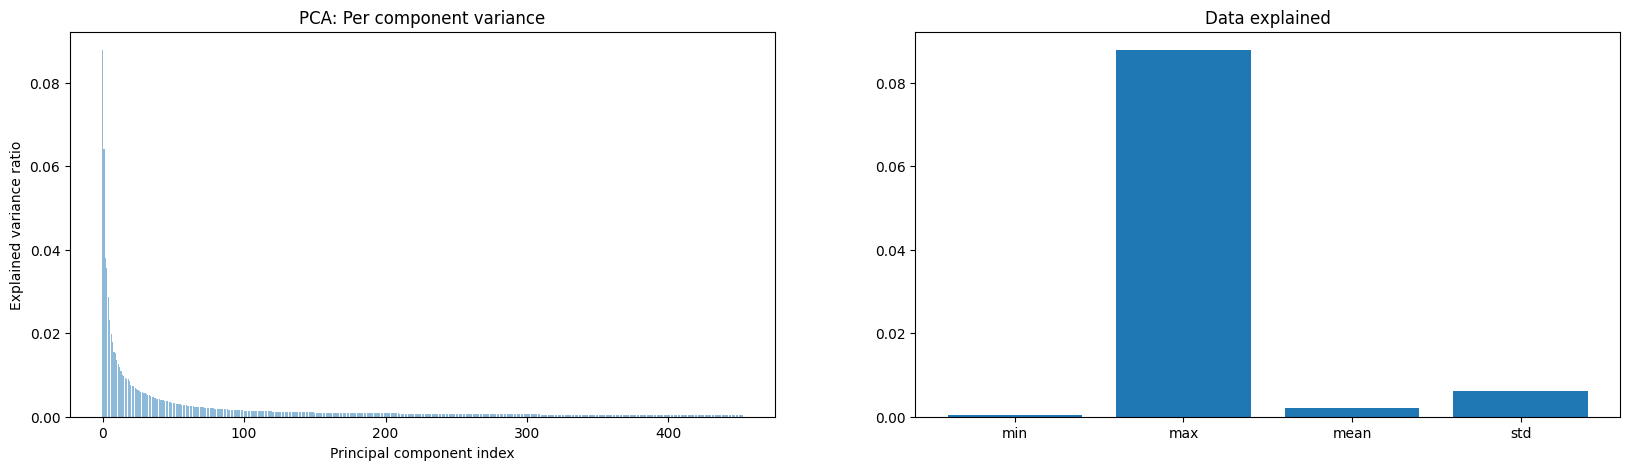

<Figure size 1000x600 with 0 Axes>

In [15]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

plt.figure(figsize=(10, 6))
axs[0].bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Varianza individuale')
axs[0].set_ylabel('Explained variance ratio')
axs[0].set_xlabel('Principal component index')
axs[0].set_title('PCA: Per component variance')

pcae = pca.explained_variance_ratio_
axs[1].set_title("Data explained")
axs[1].bar(["min", "max", "mean", "std"], [np.amin(pcae), np.amax(pcae), np.mean(pcae), np.std(pcae)])

plt.show()

## Models

ACC: 0.993
BAC: 0.993
f1: 0.9929245283018868
CM:



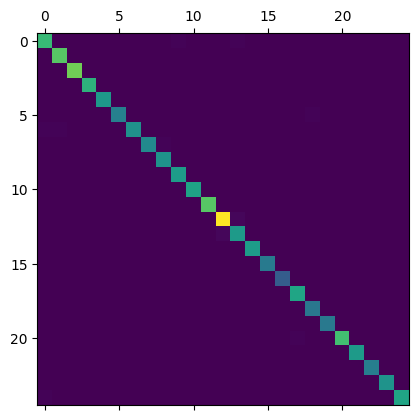

In [27]:
Xl, Xt, yl, yt = train_test_split(X, y, test_size=0.2, random_state=11)
grid = {'C':                       np.logspace(-6,3,10),
        'kernel':                  ['linear'],
        'decision_function_shape': ['ovr']}
start_time = time.time()
M = GridSearchCV(estimator  = SVC(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'balanced_accuracy',
                 n_jobs = -2)

M.fit(Xl, yl)
times["linear"] = time.time() - start_time

quality(M,Xt,yt)

In [41]:
grid = {'C':                       np.logspace(-6,3,10),
        'kernel':                  ['rbf'],
        'gamma':                   np.logspace(-6,3,10),
        'decision_function_shape': ['ovr']}
M = GridSearchCV(estimator  = SVC(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'accuracy',
                 n_jobs=-1,
                 verbose=10)
start_time = time.time()
M.fit(Xl, yl)
rbf_time = time.time() - start_time
yp = M.predict(Xt)
perr = 100*np.mean(yp != yt)
print('%Err: ' +  str(perr))
print('%CM:\n ' +  str(confusion_matrix(yt,yp)))
quality(M,Xt,yt)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
grid = {'max_depth': [34, 36, 40,45, 50]}
M = GridSearchCV(estimator  = DecisionTreeClassifier(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'accuracy',
                 n_jobs=19)
start_time = time.time()
M.fit(Xl,yl)
decision_tree_depth_time = time.time() - start_time
print('max_depth best: ' + str(M.best_params_['max_depth']))
plot_tree(M.best_estimator_)
quality(M,Xt,yt)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
grid = {'min_samples_leaf': [2,4,6,8,12,16,20,30]}
M = GridSearchCV(estimator  = DecisionTreeClassifier(),
                 param_grid = grid,
                 cv         = 3,
                 scoring    = 'accuracy')
start_time = time.time()
M.fit(X,Y)
decision_tree_leaf_time = time.time() - start_time
print('min_samples_leaf best: ' + str(M.best_params_['min_samples_leaf']))
plot_tree(M.best_estimator_)
quality(M,XT,YT)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
M = RandomForestClassifier(n_estimators=300)
start_time = time.time()
M.fit(X,Y)
random_forest_time = time.time() - start_time
quality(M,XT,YT)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
grid = {'n_estimators': [300],
        'max_features': [10,16,20,28,32,40]}
M = GridSearchCV(estimator  = RandomForestClassifier(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'accuracy',
                 n_jobs =20)
start_time = time.time()
M.fit(Xl,yl)
random_forest_grid_time = time.time() - start_time
print('n_estimators best: ' + str(M.best_params_['n_estimators']))
print('max_features best: ' + str(M.best_params_['max_features']))
quality(M,Xt,yt)

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
grid = {'n_estimators':  [50],
        'learning_rate': [.01, 0.05, .1, .5]}
M = GridSearchCV(estimator  = GradientBoostingClassifier(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'accuracy',
                 n_jobs=20)
start_time = time.time()
M.fit(Xl,yl)
gradient_boost_time = time.time() - start_time
print('n_estimators best:  ' + str(M.best_params_['n_estimators']))
print('learning_rate best: ' + str(M.best_params_['learning_rate']))
quality(M,Xt,yt)

KeyboardInterrupt: 